# Imports

In [187]:

import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import warnings
import data_func.read_data as read_data
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")
warnings.filterwarnings("ignore", category=FutureWarning, message="is_sparse is deprecated")



# Load datasets

In [188]:
dataframes = read_data.get_training_data()
X_frames_train = dataframes[0]
Y_frames_train = dataframes[1]
X_frames_test = read_data.get_test_data()


In [189]:
XTRA = X_frames_train[0]
XTRB = X_frames_train[1]
XTRC = X_frames_train[2]

YA = Y_frames_train[0]
YB = Y_frames_train[1]
YC = Y_frames_train[2]

print(XTRA.head())

        date_forecast  absolute_humidity_2m:gm3  air_density_2m:kgm3  \
0 2019-06-02 22:00:00                       7.7                1.230   
1 2019-06-02 22:15:00                       7.7                1.229   
2 2019-06-02 22:30:00                       7.7                1.228   
3 2019-06-02 22:45:00                       7.7                1.226   
4 2019-06-02 23:00:00                       7.7                1.225   

   ceiling_height_agl:m  clear_sky_energy_1h:J  clear_sky_rad:W  \
0           1744.900024                    0.0              0.0   
1           1734.000000                    0.0              0.0   
2           1723.500000                    0.0              0.0   
3           1713.400024                    0.0              0.0   
4           1703.599976                    0.0              0.0   

   cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  diffuse_rad:W  ...  \
0       1744.900024              0.0      280.299988            0.0  ...   
1       1734

In [190]:
print("A: \n", len(XTRA))
ind = XTRA[(XTRA['date_forecast'] == pd.to_datetime('2022-10-21 00:00:00'))].index
print(ind)
XTRA = XTRA.drop(ind).reset_index(drop=True)
print(len(XTRA))

print("B: \n", len(XTRB))
ind = XTRB[(XTRB['date_forecast'] == pd.to_datetime('2022-05-02 21:00:00'))].index
print(ind)
XTRB = XTRB.drop(ind).reset_index(drop=True)
print(len(XTRB))

print("C: \n",len(XTRC))
ind = XTRC[(XTRC['date_forecast'] == pd.to_datetime('2022-04-25 21:00:00'))].index
print(ind)
XTRC = XTRC.drop(ind).reset_index(drop=True)
print(len(XTRC))

A: 
 136245
Int64Index([118664], dtype='int64')
136244
B: 
 134505
Int64Index([116916], dtype='int64')
134504
C: 
 134401
Int64Index([116244], dtype='int64')
134400


[5176, 5177, 5178, 5179, 5180, 5181, 5182, 5183, 5184, 5185, 5186, 5187, 5188, 5189, 5190, 5191, 5192, 5193, 5194, 5195, 5196, 5197, 5198, 5199, 5200, 5201, 5202, 5203, 5204, 5205, 5206, 5207, 5208, 5209, 5210, 5211, 5212, 5213, 5214, 5215, 5216, 5217, 5218]
[327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 

<AxesSubplot:title={'center':'Target C Clean'}, xlabel='time'>

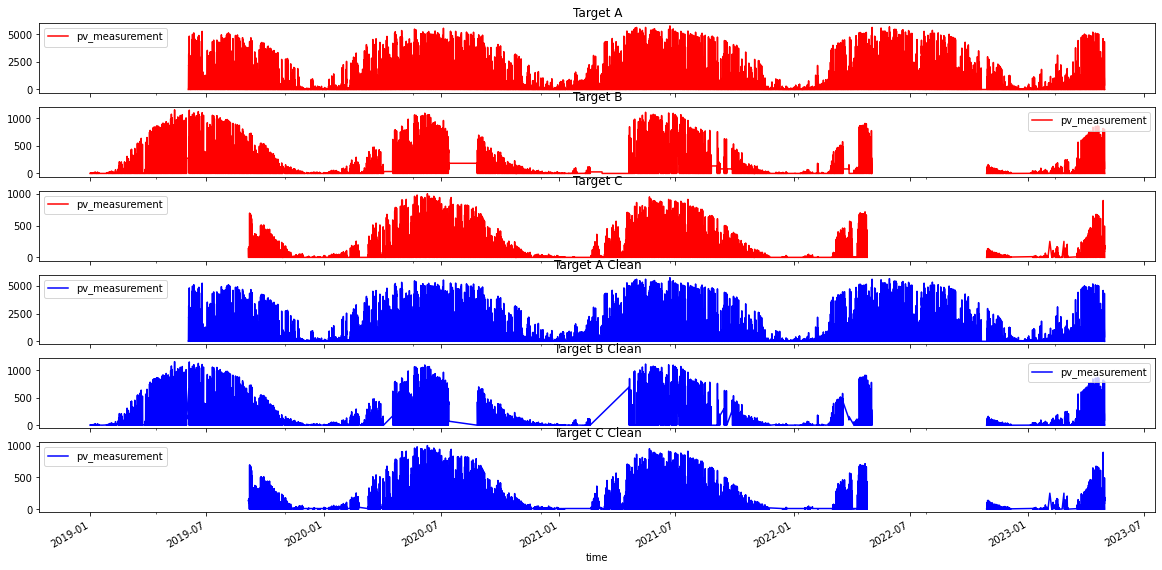

In [191]:
def fix_y_holes(y: pd.DataFrame) -> pd.DataFrame:
    Y = y
    drop_val = None
    zero_counter = 0
    index_dropper = []
    for i in range(1, len(Y)-4): # Since we match on 4 consecutive values.
        if Y['pv_measurement'].iloc[i] != 0:
            if zero_counter > 23:
                zero_list = list(range(i-zero_counter, i))
                index_dropper.extend(zero_list)
            zero_counter = 0
            if (Y['pv_measurement'].iloc[i] == Y['pv_measurement'].iloc[i+1] and Y['pv_measurement'].iloc[i+1] == Y['pv_measurement'].iloc[i+2] and Y['pv_measurement'].iloc[i+2] == Y['pv_measurement'].iloc[i+3]):
                drop_val = Y['pv_measurement'].iloc[i]
        if Y['pv_measurement'].iloc[i] == 0:
            zero_counter += 1
        if Y['pv_measurement'].iloc[i] == drop_val:
            index_dropper.append(i)
        else:
            if drop_val != None:
                drop_val = None
    print(index_dropper)
    return Y.drop(index_dropper)
    
import matplotlib.pylab as plt
fig, axs = plt.subplots(6, 1, figsize=(20, 10), sharex=True)
YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Target A', color='red')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1], title='Target B', color='red')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[2], title='Target C', color='red')


YA = fix_y_holes(YA)
YB = fix_y_holes(YB)
YC = fix_y_holes(YC)

YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[3], title='Target A Clean', color='blue')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[4], title='Target B Clean', color='blue')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[5], title='Target C Clean', color='blue')



# Data clean up an aggregation

In [192]:
# Making sure that target values line up with x_values
import data_func.aggregation as data_agg

categorical_col = ['dew_or_rime:idx', 'precip_type_5min:idx', 'is_day:idx', 'is_in_shadow:idx']

def aggregate_correct_x(x: pd.DataFrame) -> pd.DataFrame:
   '''
   Takes a given dataframe and returns an aggregated dataframe based on selected categorical functions. 
   Assumes grouping of 4.
   '''
   categorical = x[["date_forecast"] + categorical_col]
   mean = x.drop(columns=categorical_col)

   categorical = data_agg.gen_agg(categorical, agg_type=data_agg.stocastic_median)
   mean = data_agg.gen_agg(mean, "mean")

   return pd.merge(categorical, mean, on="date_forecast")

def data_allign(x_train, y_train):

  y_train.dropna(inplace=True)
  x_train = aggregate_correct_x(x_train)
  combined_data = pd.merge(x_train, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns=['time', 'pv_measurement'], inplace=True)
    
  return combined_data, y_train



X_train = [XTRA, XTRB, XTRC]
Y_train = [YA, YB, YC]

for i in range(len(X_train)):
    X_train[i], Y_train[i] = data_allign(X_train[i], Y_train[i])

for j in range(len(X_frames_test)):
    X_frames_test[j] = aggregate_correct_x(X_frames_test[j])


# Feature engineering

In [193]:
import data_func.timeseasonality as DTS
import data_func.one_hot_encoding as OHE
import data_func.date_forecast as DTF
import data_func.combine_columns as CC

columns_to_drop = ['snow_density:kgm3', 'elevation:m', 'snow_drift:idx', 'date_forecast']

for i in range(len(X_train)):
    X_train[i] = DTS.append_seasonal_columns(X_train[i])
    X_train[i] = DTF.date_forecast_columns(X_train[i])
    X_train[i]['above_300_kelvin'] = np.where(X_train[i]['t_1000hPa:K'] > 298, 1, 0)    

    #X_train[i] = CC.combine_columns_division(X_train[i], 'clear_sky_total', ['clear_sky_energy_1h:J', 'clear_sky_rad:W'])


for i in range(len(X_frames_test)):
    X_frames_test[i] = DTS.append_seasonal_columns(X_frames_test[i])
    X_frames_test[i] = DTF.date_forecast_columns(X_frames_test[i])
    X_train[i]['above_300_kelvin'] = np.where(X_train[i]['t_1000hPa:K'] > 298, 1, 0)
    #X_frames_test[i] = CC.combine_columns_division(X_frames_test[i], 'clear_sky_total', ['clear_sky_energy_1h:J', 'clear_sky_rad:W'])


# THIS SECTION CAN ONLY WORK IF THE PREVIOUS AGGREGATION IS DONE INDIVIDUALLY FOR CATEGORICAL DATA
# import data_func.one_hot_encoding as OHE

def fix_categorical(train: pd.DataFrame, test: pd.DataFrame):
     temp = pd.concat([train, test], ignore_index=True)
     index_train = temp[(temp['date_forecast'] < test['date_forecast'].iloc[0])].index
     return temp.drop(index_train)

OH_columns = ['dew_or_rime:idx', 'precip_type_5min:idx']

for i in range(len(X_frames_test)):
     X_train[i] = OHE.one_hot_encode(X_train[i],OH_columns)
     X_frames_test[i] = OHE.one_hot_encode(X_frames_test[i], OH_columns)
     X_frames_test[i] = fix_categorical(X_train[i], X_frames_test[i])
     X_train[i].drop(columns=columns_to_drop, inplace=True)
     X_frames_test[i].drop(columns=columns_to_drop, inplace=True)

def combine_features(df, listOfFeaturesToCombine):
    for features in listOfFeaturesToCombine:
        new_col_name = features[0] + '_mean'
        df[new_col_name] = df[features].mean(axis=1)
        #df.drop(columns=features, inplace=True)
    return df

listOfFeaturesToCombine = [['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa'],
                            ["diffuse_rad:W", "direct_rad:W"], 
                           ["diffuse_rad_1h:J", "direct_rad_1h:J"],
                    ]
for i in range(len(X_train)):
    X_train[i] = combine_features(X_train[i], listOfFeaturesToCombine)
    X_frames_test[i] = combine_features(X_frames_test[i], listOfFeaturesToCombine)


In [194]:
# Show null values for all training sets

count_a = X_train[0].isna().sum()
count_b = X_train[1].isna().sum()
count_c = X_train[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]

,A,B,C
ceiling_height_agl:m,6126,4096,4383
cloud_base_agl:m,2362,1843,1857


In [195]:
# Show null values for all test sets

count_a = X_frames_test[0].isna().sum()
count_b = X_frames_test[1].isna().sum()
count_c = X_frames_test[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]

,A,B,C
ceiling_height_agl:m,188,180,202
cloud_base_agl:m,70,65,88
above_300_kelvin,720,720,720
dew_or_rime:idx_-1,720,720,0
precip_type_5min:idx_2,720,720,720
precip_type_5min:idx_3,720,720,720


In [196]:
## Multiplying effective cloud coverage with clear sky radiation
from data_func.feature_engineering.combine import multiply_columns

def flip_percent(x):
    return (x-100)*-1

for i in range(len(X_train)):
    A = X_train[i]['effective_cloud_cover:p'].apply(flip_percent)
    B = X_train[i]['clear_sky_rad:W']
    AT = X_frames_test[i]['effective_cloud_cover:p'].apply(flip_percent)
    BT = X_frames_test[i]['clear_sky_rad:W']

    X_train[i]['COMB_clear_sky_rad_X_eff_cloud_cover'] = multiply_columns(A, B)
    X_frames_test[i]['COMB_clear_sky_rad_X_eff_cloud_cover'] =  multiply_columns(AT, BT)
    X_train[i].drop(columns=['clear_sky_rad:W', 'clear_sky_energy_1h:J'])

In [197]:
from math import sin, radians
def sinus_degrees(x):
    return sin(radians(x))

for i in range(len(X_train)):
    A = X_train[i]['sun_elevation:d'].apply(sinus_degrees)
    B = X_train[i]['air_density_2m:kgm3']
    AT = X_frames_test[i]['sun_elevation:d'].apply(sinus_degrees)
    BT = X_frames_test[i]['air_density_2m:kgm3']

    X_train[i]['COMB_sun_elevation_air_density'] = multiply_columns(A, B)
    X_frames_test[i]['COMB_sun_elevation_air_density'] =  multiply_columns(AT, BT)
    X_train[i].drop(columns=['air_density_2m:kgm3'], inplace=True)
    X_frames_test[i].drop(columns=['air_density_2m:kgm3'], inplace=True)

In [198]:
def flip_ceiling_height(x):
    flip_val = 12005.7
    null_dist = 1000
    return abs(x-(flip_val+null_dist))

for i in range(len(X_train)):
    X_frames_test[i]['ceiling_height_agl:m'] = X_frames_test[i]['ceiling_height_agl:m'].apply(flip_ceiling_height)
    X_train[i]['ceiling_height_agl:m']= X_train[i]['ceiling_height_agl:m'].apply(flip_ceiling_height)

In [199]:

def flip_cloud_base(x):
    flip_val = 11467.8
    null_dist = 1000
    return abs(x-(flip_val+null_dist))
for i in range(len(X_train)):
    X_frames_test[i]['cloud_base_agl:m'] = X_frames_test[i]['cloud_base_agl:m'].apply(flip_ceiling_height)
    X_train[i]['cloud_base_agl:m']= X_train[i]['cloud_base_agl:m'].apply(flip_ceiling_height)

In [200]:
# Removes nan or fills it
values = {"ceiling_height_agl:m": 0, "cloud_base_agl:m": 0}

for i in range(len(X_train)):
    X_train[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(0, inplace=True) # fills remaining NaN vals with 0, (specifically for one-hot encoded columns with NaN values)



In [201]:

# Combine datasets B and C

def combine_bc(frames: [pd.DataFrame]):
    
    for i, frame in enumerate(frames):
        if i == 0:
            frame['location'] = '0'
        elif i == 1:
            frame['location'] = '1'
    combined = pd.concat(frames)
    combined = combined.reset_index(drop=True)
    combined['location'] = combined['location'].astype('float64')

    return combined

#X_train_bc = combine_bc([X_train[1], X_train[2]])
#X_train_bc = OHE.one_hot_encode(X_train_bc, ["location"])

#X_frames_test_bc = combine_bc([X_frames_test[1], X_frames_test[2]])
#X_frames_test_bc = OHE.one_hot_encode(X_frames_test_bc, ["location"])
#Y_train_bc = pd.concat([Y_train[1], Y_train[2]], ignore_index=True)


In [202]:
drop_cols_a = [
    "fresh_snow_12h:cm", 
    "fresh_snow_1h:cm",
    "fresh_snow_24h:cm",
    "fresh_snow_3h:cm",
    "fresh_snow_6h:cm",
    "snow_depth:cm",
    "snow_melt_10min:mm",
    "snow_water:kgm2"
]

X_train[0].drop(columns=drop_cols_a, inplace=True)
X_frames_test[0].drop(columns=drop_cols_a, inplace=True)

# Training the model

In [203]:

# Split the data into training and validation sets

x_train_a, x_val_a, y_train_a, y_val_a = train_test_split(X_train[0], Y_train[0], test_size=0.3, random_state=42)
x_train_b, x_val_b, y_train_b, y_val_b = train_test_split(X_train[1], Y_train[1], test_size=0.3, random_state=42)
x_train_c, x_val_c, y_train_c, y_val_c = train_test_split(X_train[2], Y_train[2], test_size=0.3, random_state=42)

# Use params from hyperparameter tuning using optuna
#params_a = {'random_state': 42, 'max_depth': 8, 'learning_rate': 0.06749043102808519, 'n_estimators': 885, 'min_child_weight': 3, 'gamma': 0.09742083144148345, 'subsample': 0.8847103741988528, 'colsample_bytree': 0.8503503049152975, 'reg_alpha': 0.012108852929559821, 'reg_lambda': 0.28779285121150633}
params_a = {'random_state': 42, 'n_estimators': 980, 'max_depth': 9, 'learning_rate': 0.029035565559484028, 'subsample': 0.8393121619033767, 'colsample_bytree': 0.7589542758688459}
# params_b = {'random_state': 42, 'max_depth': 9, 'learning_rate': 0.04778208620335073, 'n_estimators': 998, 'min_child_weight': 4, 'gamma': 0.7276770076424136, 'subsample': 0.41548412574068205, 'colsample_bytree': 0.671005991193969, 'reg_alpha': 0.15578107366887714, 'reg_lambda': 0.11160337145958334}
params_b = {'random_state': 42, 'n_estimators': 955, 'max_depth': 9, 'learning_rate': 0.02949625834198986, 'subsample': 0.8030196155828968, 'colsample_bytree': 0.72518389089994}
params_c = {'random_state': 42, 'n_estimators': 727, 'max_depth': 8, 'learning_rate': 0.08609213174337473, 'subsample': 0.8107057409889747, 'colsample_bytree': 0.8763563332327975}
model_a = xgb.XGBRegressor(**params_a)
model_b = xgb.XGBRegressor(**params_b)
model_c = xgb.XGBRegressor(**params_c)


model_a.fit(x_train_a, y_train_a)
model_b.fit(x_train_b, y_train_b)
model_c.fit(x_train_c, y_train_c)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8763563332327975, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.08609213174337473, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=727, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

# Evaluate prediction

In [204]:
# Evaluate the model based on the validation data
y_val_a_pred = model_a.predict(x_val_a) * x_val_a['is_day:idx']
y_val_b_pred = model_b.predict(x_val_b) * x_val_b['is_day:idx']
y_val_c_pred = model_c.predict(x_val_c) * x_val_c['is_day:idx']

mae_a = mean_absolute_error(y_val_a, y_val_a_pred)
mse_a = mean_squared_error(y_val_a, y_val_a_pred)
print("MAE for A: ", mae_a)
print("MSE for A: ", mse_a)
mae_b = mean_absolute_error(y_val_b, y_val_b_pred)
mse_b = mean_squared_error(y_val_b, y_val_b_pred)
print("MAE for B: ", mae_b)
print("MSE for B: ", mse_b)
mae_c = mean_absolute_error(y_val_c, y_val_c_pred)
mse_c = mean_squared_error(y_val_c, y_val_c_pred)
print("MAE for C: ", mae_c)
print("MSE for C: ", mse_c)
print("Mean MAE: ", (mae_a + mae_b + mae_c) / 3)
print("Total MAE: ", mae_a + mae_b + mae_c)

# Evaluate the predictions

score_a = model_a.score(x_val_a, y_val_a)
score_b = model_b.score(x_val_b, y_val_b)
score_c = model_c.score(x_val_c, y_val_c)

print("Score A: ", score_a)
print("Score B: ", score_b)
print("Score C: ", score_c)
print('')

# Get feature importance scores
models = [(model_a, 'A'), (model_b, 'B'), (model_c, 'C')]
for model in models:

    feature_importance_scores = model[0].feature_importances_

# Create a DataFrame to associate features with their importance scores
    feature_importance_df1 = pd.DataFrame({'Feature': x_train_a.columns, 'Importance': feature_importance_scores})

# Sort features by importance in descending order
    feature_importance_df1 = feature_importance_df1.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importance scores
    pd.set_option('display.max_rows', 500)
    feature_importance_df1.head(500)
    print(f'Model {model[1]}')
    print(feature_importance_df1)
    pd.reset_option('display.max_rows')


MAE for A:  160.86075801716865
MSE for A:  136929.22945048497
MAE for B:  23.545095056989798
MSE for B:  3415.95350518514
MAE for C:  21.677966217285455
MSE for C:  2652.3888035783552
Mean MAE:  68.6946064304813
Total MAE:  206.0838192914439
Score A:  0.8951563130342436
Score B:  0.9233931491739702
Score C:  0.9176341245790541

Model A
                                 Feature  Importance
54                    diffuse_rad:W_mean    0.573756
55                 diffuse_rad_1h:J_mean    0.116912
10                          direct_rad:W    0.048480
40                                 hours    0.018144
14                        precip_5min:mm    0.015823
8                          diffuse_rad:W    0.009524
21                         sun_azimuth:d    0.009087
43                          week_of_year    0.008838
33                             sinus_day    0.008834
56  COMB_clear_sky_rad_X_eff_cloud_cover    0.008427
57        COMB_sun_elevation_air_density    0.008376
36                        

ValueError: All arrays must be of the same length

# Make predictions

In [ ]:
# Train the model on the entire training data
model_a.fit(X_train[0], Y_train[0])
model_b.fit(X_train[1], Y_train[1])
model_c.fit(X_train[2], Y_train[2])

y_pred_a = model_a.predict(X_frames_test[0]) * X_frames_test[0]['is_day:idx']
y_pred_b = model_b.predict(X_frames_test[1]) * X_frames_test[1]['is_day:idx']
y_pred_c = model_c.predict(X_frames_test[2]) * X_frames_test[2]['is_day:idx']
print(len(y_pred_a))

y_pred = np.concatenate((y_pred_a, y_pred_b, y_pred_c), axis=0)



720


In [ ]:
print(len(y_pred_a), len(X_frames_test[0]))
print(len(y_pred_b), len(X_frames_test[1]))
print(len(y_pred_c), len(X_frames_test[2]))

720 720
720 720
720 720


In [ ]:
for i in range(len(y_pred)):
    if y_pred[i] < 10: 
        y_pred[i] = 0



## Compare with best submission

(2160,)
(2160,)


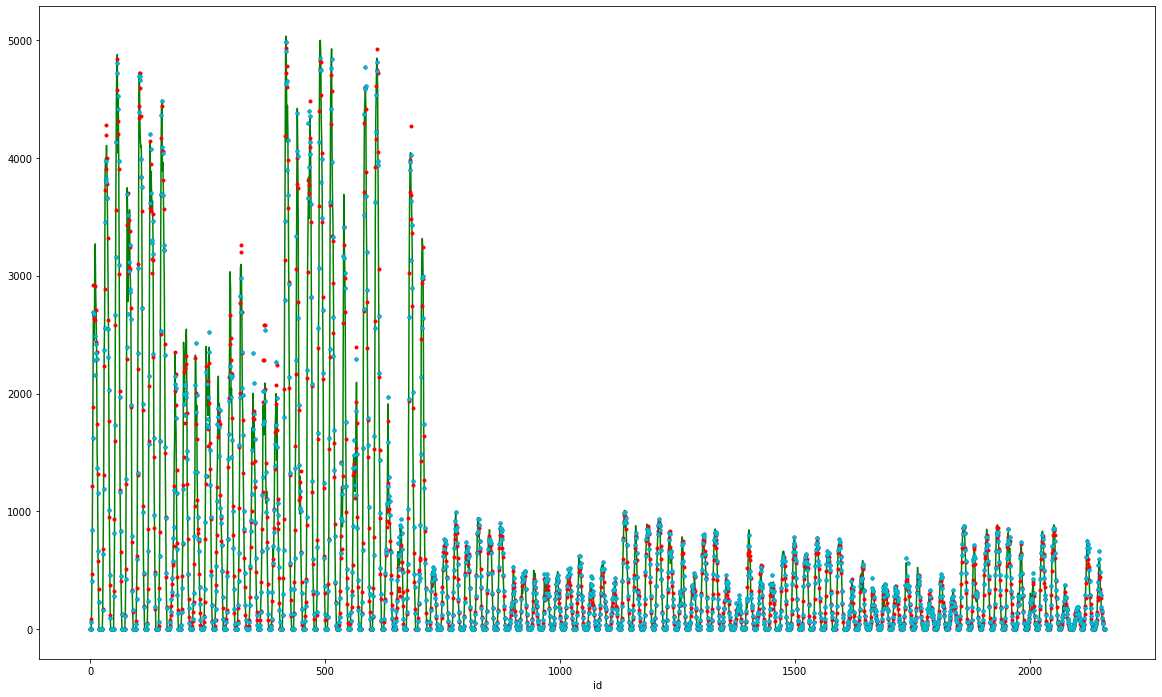

In [ ]:
best_submission = pd.read_csv('./submissions/submission_cat_148LESSSSGO.csv')
best2_submission = pd.read_csv('./submissions/submission_xg154.4.csv')
best3_submission = pd.read_csv('./submissions/submission_xg154.4.csv')

print(y_pred.shape)
print(best_submission['prediction'].shape)
plt.figure(figsize=(20,12))

plt.plot(y_pred, 'g')
plt.plot(best_submission['prediction'], 'r.')
plt.plot(best2_submission['prediction'], 'b.')
plt.plot(best3_submission['prediction'], 'c.')
plt.xlabel("id")
plt.show()


# Create submission

In [ ]:
y_test_pred = y_pred
print(len(y_test_pred))

test = pd.read_csv('../data/test.csv')
test['prediction'] = y_test_pred
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submissions/submission_xg.csv', index=False)


2160
